In [1]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [2]:
import numpy as np
import gc
import functools
import random
import datetime
import scipy
import h5py
import os
import pathlib
import nrrd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib
import sys
import json
import skimage
from skimage import io, draw
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.ndimage import zoom
from sklearn.model_selection import KFold
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def create_dataset(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2) #113
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.359))
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                image_c =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                image_c = np.transpose(image_c, (2, 1, 0))
                image_c = image_c[::-1, :, :]
            
                img_data_array.append(image_c)
                # reading markups
                j = 0
            if (file.endswith(".json")) and j<1:
                #json_filename = glob(img_folder +  '/*.json')[-1]
                #data = open(json_filename,'r')
                json_path= os.path.join(img_folder, dir1, file)
                data = open(json_path,'r')
                
                jsondata = data.read()
                # Parse
                obj=json.loads(jsondata)
                list=obj['markups']
                # getting LPS coordinates
                points1 = list[0]["controlPoints"][0]["position"]
                points2 = list[0]["controlPoints"][1]["position"]
                points3 = list[0]["controlPoints"][2]["position"]
                # converting to i,j,k coordinate
                i1 = round((points1[0]-header['space origin'][0])/header['space directions'][0][0])
                j1 = round((points1[1]-header['space origin'][1])/header['space directions'][1][1])
                k1 = round((points1[2]-header['space origin'][2])/header['space directions'][2][2])
                i2 = round((points2[0]-header['space origin'][0])/header['space directions'][0][0])
                j2 = round((points2[1]-header['space origin'][1])/header['space directions'][1][1])
                k2 = round((points2[2]-header['space origin'][2])/header['space directions'][2][2])
                i3 = round((points3[0]-header['space origin'][0])/header['space directions'][0][0])
                j3 = round((points3[1]-header['space origin'][1])/header['space directions'][1][1])
                k3 = round((points3[2]-header['space origin'][2])/header['space directions'][2][2])
                # correcting coordinates of mask for resized image and creating mask
                i_s = int(round((i1-(i3-i1))*0.705))  # starting points of 3D cuboid box mask
                j_s = int(round((j1-(j2-j1))*0.588))

                i_e = int(round((i1+(i3-i1))*0.705))   # ending points of 3D cuboid box mask
                j_e = int(round((j1+(j2-j1))*0.588))
                
                k_s = int(round(k2-25)*0.359)  
                k_e = int(round(k2-23)*0.359)
                
                # Making 3D cuboid box mask
                rr, cc, dd = skimage.draw.rectangle(start=(i_s, j_s, k_s), end=(i_e, j_e, k_e)) 
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask[rr, cc, dd] = True
                mask = mask[:, ::-1, :]
                all_masks = [mask] * i
                mask_array.append(all_masks)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
### extract the image array and mask array
img_data_train, mask_all_train =create_dataset(r'C:/Dhruba Research Drive/f4')


## For Training Set ###
mask_all_train = combine_dims(mask_all_train, 0) # combines dimension 1 and 2
#imgs.shape
x1=np.array(img_data_train, np.float32)
#print(x1.shape)
y1=np.array(mask_all_train, np.float32)
#print(y1.shape)

X_train = np.expand_dims(x1, axis=4)
y_train = np.expand_dims(y1, axis=4)

print(X_train.shape)
print(y_train.shape)

img_aug_array=[]
mask_aug_array=[]
for d in range (mask_all_train.shape[0]):
#     img = img_data_train[d]
#     mask = mask_all_train[d]
    for e in range (4):
        img = np.rot90(np.transpose(img_data_train[d], (2, 1, 0)), e, (1,2))
        img = np.transpose(img, (2, 1, 0))
        img_aug_array.append(img)
        mask = np.rot90(np.transpose(mask_all_train[d], (2, 1, 0)), e, (1,2))
        mask = np.transpose(mask, (2, 1, 0))
        mask_aug_array.append(mask)

X_train_aug = np.array(img_aug_array, np.float32)
X_train_aug = np.expand_dims(X_train_aug, axis=4)
print(X_train_aug.shape)

y_train_aug = np.array(mask_aug_array, np.float32)
y_train_aug = np.expand_dims(y_train_aug, axis=4)
print(y_train_aug.shape)

(175, 128, 128, 32, 1)
(175, 128, 128, 32, 1)
(700, 128, 128, 32, 1)
(700, 128, 128, 32, 1)


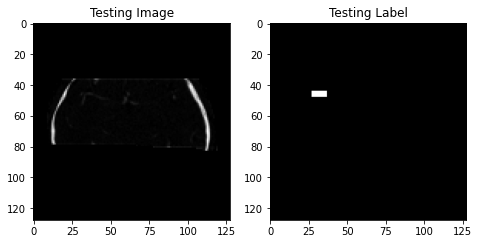

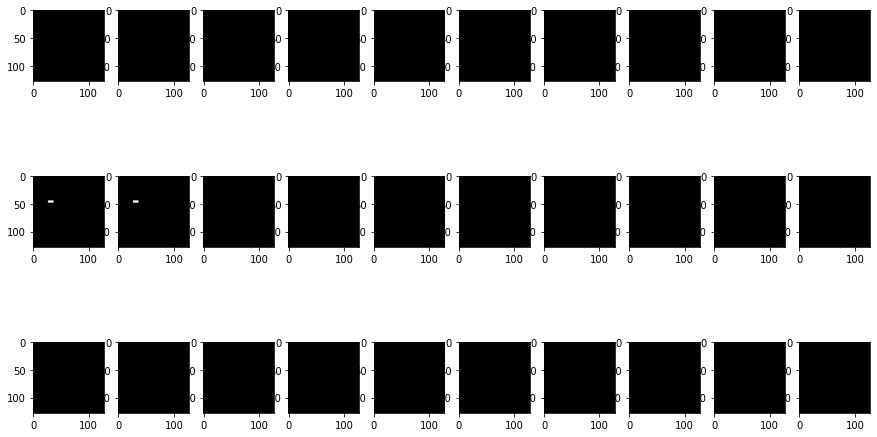

In [12]:
# test_img_number = 10
# test_img = X_train[test_img_number]
# ground_truth=y_train[test_img_number]

# test_img_input = np.expand_dims(test_img, 0)
# ground_truth_argmax = ground_truth[:, :, :, 0]

# slice = 11 #6-7 !!!
# plt.figure(figsize=(12,8))
# plt.subplot(231)
# plt.title('Testing Image')
# x_t=np.transpose(test_img, (2, 1, 0, 3))
# #x_t = x_t[:, :, :, 0]
# plt.imshow(x_t[slice], cmap='gray')
# #plt.imshow(test_img[slice,:,:,0], cmap='gray')

# plt.subplot(232)
# plt.title('Testing Label')
# y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
# plt.imshow(y_t[slice], cmap ='gray')

# plt.figure(figsize=(15,30))
# for i in range(30):
#     plt.subplot(10, 10, i+1)
#     plt.imshow(y_t[(i+1)], cmap='gray')

In [4]:
def RB1(inp, f):              # Residual unit 1
    X = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same')(inp)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = Conv3D(f, kernel_size = (3,3,3), padding = 'same')(X)
    X = BatchNormalization(axis = -1)(X)
    
    # Conv attention module
    X = cbam_block(X)
    
    X_s = Conv3D(f, kernel_size = (3,3,3), padding = 'same')(inp)
    X_s = BatchNormalization(axis = -1)(X_s)
    
    X = layers.Add()([X, X_s])
    out = Activation('relu')(X)
    return out

def RB2(inp, f):             # Residual unit 2
    X = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same')(inp)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = Conv3D(f, kernel_size = (3,3,3), padding = 'same')(X)
    X = BatchNormalization(axis = -1)(X)
    
    # Conv attention module
    X = cbam_block(X)
    
    X = layers.Add()([X, inp])
    out = Activation('relu')(X)
    return out

def cbam_block(cbam_feature, ratio=16):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521."""

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=16):

    channel = input_feature.shape[-1] # if channel last, axis = -1 or if channel first then axis = 1
    i_shape = input_feature.shape[1]  #shape of input 

    shared_layer_one = Conv3D(channel//ratio, 1, activation='relu', use_bias=False)
    shared_layer_two = Conv3D(channel, 1, use_bias=False)

    avg_pool = AveragePooling3D(pool_size=(i_shape, i_shape, i_shape), strides=i_shape, padding='same')(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = MaxPooling3D(pool_size=(i_shape, i_shape, i_shape), strides=i_shape, padding='same')(input_feature)  
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    #if channel first then use this
    #cbam_feature = Permute((4, 1, 2, 3))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    channel = input_feature.shape[-1]  # if channel last, axis = -1 or if channel first then axis = 1
    #if channel first then use this
    #cbam_feature = Permute((2,3,4,1))(input_feature)

    avg_pool = Lambda(lambda x: K.mean(x, axis=4, keepdims=True))(input_feature)  #(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=4, keepdims=True))(input_feature)  #(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=4)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv3D(filters = 1, kernel_size=kernel_size, strides=1, padding='same',
                    activation=None, kernel_initializer='he_normal', use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1
    cbam_feature = tf.sigmoid(cbam_feature, 'sigmoid')
    
    #if channel first then use this
    #cbam_feature = Permute((4, 1, 2, 3))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

def A1(inp): 
    A1 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=1, padding='same')(inp)
    return A1

def A3(inp): 
    A3 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=3, padding='same')(inp)
    return A3

def A5(inp):
    A5 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=5, padding='same')(inp)
    return A5  

def conv1x1(inp):
    conv1x1 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=1, padding='same')(inp)
    return conv1x1
    
def DAC(inp):
    
    atrous1 =  tf.nn.relu(A1(inp))
    atrous2 =  tf.nn.relu(conv1x1(A3(inp)))
    atrous3 =  tf.nn.relu(conv1x1(A3(A1(inp))))
    atrous4 =  tf.nn.relu(conv1x1(A5(A3(A1(inp)))))
    
    out = Add()([atrous1, atrous2, atrous3, atrous4])
    return out

def _resize_by_axis_trilinear(images, size_0, size_1, ax):
    """
    Resize image bilinearly to [size_0, size_1] except axis ax.
        :param image: a tensor 4-D with shape 
                        [batch, d0, d1, d2, channels]
        :param size_0: size 0
        :param size_1: size 1
        :param ax: axis to exclude from the interpolation
    """
    resized_list = []

    # unstack the image in 2d cases
    unstack_list = tf.unstack(images, axis = ax)
    for i in unstack_list:
        # resize bilinearly
        resized_list.append(tf.compat.v1.image.resize_bilinear(i, [size_0, size_1]))
    stack_img = tf.stack(resized_list, axis=ax)

    return stack_img


def resize_trilinear(images, size):
    """
    Resize images to size using trilinear interpolation.
        :param images: A tensor 5-D with shape 
                        [batch, d0, d1, d2, channels]
        :param size: A 1-D int32 Tensor of 3 elements: new_d0, new_d1,
                        new_d2. The new size for the images.
    """
    assert size.shape[0] == 3
    resized = _resize_by_axis_trilinear(images, size[0], size[1], 2)
    resized = _resize_by_axis_trilinear(resized, size[0], size[2], 1)
    return resized


# jumping some lines...


def resize_multilinear_tf(images, size):
    """
    Resize images to size using multilinear interpolation.
        :param images: A tensor with shape 
                        [batch, d0, ..., dn, channels]
        :param size: A 1-D int32 Tensor. The new size for the images.
    """
    if size.shape[0] == 2:
        resized = tf.compat.v1.image.resize_bilinear(images, size)
    elif size.shape[0] == 3:
        resized = resize_trilinear(images, size)
#     elif size.shape[0] == 4:
#         resized = resize_tetralinear(images, size)
    else:
        raise NotImplementedError('resize_multilinear_tf: dimensions \
                                    higuer than 3 are not supported.')
    return resized


########### We do not use this 'resize_by_axis' in this project ############3
def resize_by_axis(image, dim_1, dim_2, ax, is_grayscale):

    resized_list = []


    if is_grayscale:
        unstack_img_depth_list = [tf.expand_dims(x,2) for x in tf.unstack(image, axis = ax)]
        for i in unstack_img_depth_list:
            resized_list.append(tf.compat.v1.image.resize_images(i, [dim_1, dim_2],method=0))
        stack_img = tf.squeeze(tf.stack(resized_list, axis=ax))
        print(stack_img.get_shape())

    else:
        unstack_img_depth_list = tf.unstack(image, axis = ax)
        for i in unstack_img_depth_list:
            resized_list.append(tf.compat.v1.image.resize_images(i, [dim_1, dim_2],method=0))
        stack_img = tf.stack(resized_list, axis=ax)

    return stack_img

# resized_along_depth = resize_by_axis(x,8,8,2, True)
# resized_along_width = resize_by_axis(resized_along_depth,8,8,1,True)

#################################################################################



# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [5]:
#for Adam optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

###########################################################

ALPHA = 0.2
BETA = 0.8
GAMMA = 1   #0.75
SMOOTH=1e-9

def FocalTversky(y_true, y_pred, smooth=SMOOTH, alpha=ALPHA, beta=BETA):
    
        # Don't flatten label and prediction tensors
        y_true_pos = y_true
        y_pred_pos = y_pred
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((y_true_pos * y_pred_pos))
        FN = K.sum((y_true * (1-y_pred_pos)))
        FP = K.sum(((1-y_true_pos) * y_pred_pos))      
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        return Tversky
    
def FocalTverskyLoss(y_true, y_pred, gamma=GAMMA):
        tv = FocalTversky(y_true, y_pred)
        FocalTversky_m = K.pow((1 - tv), gamma) 
        return FocalTversky_m
    
#optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optim = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [6]:
kfold = KFold(n_splits=5, shuffle=False)

# 5-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train_aug, y_train_aug):
    inputs = Input((128,128,32,1))

    # 3D Conv layers starts below
    conv1 = Conv3D(24, kernel_size=(3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(24, kernel_size=(3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(conv1)


    # Residual block 1
    X1 = RB1(pool1, 32)
    X1 = RB2(X1, 32)
    X1 = RB2(X1, 32)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(X1)

    # Residual block 2
    X2 = RB1(pool2, 64)
    X2 = RB2(X2, 64)
    X2 = RB2(X2, 64)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(X2)

    # Residual block 3
    X3 = RB2(pool3, 64) #input shapes matches, so no need for RB1
    X3 = RB2(X3, 64)
    X3 = RB2(X3, 64)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(X3)

    # Residual block 4
    X4 = RB2(pool4, 64) #input shapes matches, so no need for RB1
    X4 = RB2(X4, 64)
    X4 = RB2(X4, 64)

    dense_atrous_conv = DAC(X4)

    size = np.ones((3), dtype=np.int32)
    size[0] = dense_atrous_conv.shape[1]
    size[1] = dense_atrous_conv.shape[2]
    size[2] = dense_atrous_conv.shape[3]

    #pooling1 = pool2(dense_atrous_conv)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(dense_atrous_conv)
    pool2 = Conv3D(1, kernel_size=1, padding='same')(pool2)
    pool2 = resize_multilinear_tf(pool2, size)

    #pooling2 = pool3(dense_atrous_conv)
    pool3 = MaxPooling3D(pool_size=(3, 3, 3), strides=3, padding='same')(dense_atrous_conv)
    pool3 = Conv3D(1, kernel_size=1, padding='same')(pool3)
    pool3 = resize_multilinear_tf(pool3, size)

    #pooling3 = pool5(dense_atrous_conv)
    pool5 = MaxPooling3D(pool_size=(5, 5, 5), strides=5, padding='same')(dense_atrous_conv)
    pool5 = Conv3D(1, kernel_size=1, padding='same')(pool5)
    pool5 = resize_multilinear_tf(pool5, size)

    #pooling4 = pool6(dense_atrous_conv)
    pool6 = MaxPooling3D(pool_size=(6, 6, 6), strides=6,  padding='same')(dense_atrous_conv)
    pool6 = Conv3D(1, kernel_size=1, padding='same')(pool6)
    pool6 = resize_multilinear_tf(pool6, size)

    Multi_Kernel_Pooling = tf.concat([pool2, pool3, pool5, pool6, dense_atrous_conv], -1)

    #Multi_Kernel_Pooling = RMP(dense_atrous_conv)

    ## Feedback path ##
    # Deconvolutional Layer 1
    deconv1 = Conv3DTranspose(64, kernel_size = 2, strides=(2, 2, 2), padding='same')(Multi_Kernel_Pooling)#(dense_atrous_conv)

    # Combining Unit 1
    C1 = tf.keras.layers.concatenate([deconv1, X3], axis = -1)

    # Residual block 5
    X5 = RB1(C1, 64) 
    X5 = RB2(X5, 64)
    X5 = RB2(X5, 64)

    # Deconvolutional Layer 2
    deconv2 = Conv3DTranspose(64, kernel_size = 2, strides=(2, 2, 2), padding='same')(X5)

    # Combining Unit 2
    C2 = tf.keras.layers.concatenate([deconv2, X2], axis = -1)

    # Residual block 6
    X6 = RB2(C2, 128)  #input shapes matches, so no need for RB1
    X6 = RB2(X6, 128)
    X6 = RB2(X6, 128)

    deconv3 = Conv3DTranspose(32, kernel_size = 2, strides=(2, 2, 2), padding='same')(X6)

    deconv4 = Conv3DTranspose(24, kernel_size = 2, strides=(2, 2, 2), padding='same')(deconv3)

    ##########################################################################################

    # Final 3D Conv layers 
    conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(deconv4)
    conv2 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Conv3D(1, 1, activation = 'sigmoid')(conv2)

    model2 = Model(inputs = inputs, outputs = conv2)
    
    model2.compile(optimizer=optim,
              loss=FocalTverskyLoss,
              metrics=[FocalTversky])
    
    filepath = 'fold'f'{fold_no}''.epoch{epoch:01d}-loss{val_loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                                 monitor='val_loss',
                                 verbose=1, 
                                 save_best_only=False,
                                 mode='min')
    callbacks = [checkpoint]
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    result = model2.fit(X_train_aug[train], y_train_aug[train],
                    batch_size = 10,
                    epochs = 10,
                    verbose=1,
                    validation_data=(X_train_aug[test], y_train_aug[test]),
                    callbacks=callbacks)
    #del result
    #del model
    #gc.collect()
#     tf.keras.backend.clear_session()  
    # Increase fold number
    fold_no = fold_no + 1 

------------------------------------------------------------------------
Training for fold 1 ...
Train on 2800 samples, validate on 700 samples
Epoch 1/10
2800/2800 [==============================] - ETA: 0s - loss: 0.8976 - FocalTversky: 0.1024

C:\Users\dhruba\.conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: saving model to fold1.epoch1-loss1.00.hdf5
2800/2800 [==============================] - 755s 270ms/sample - loss: 0.8976 - FocalTversky: 0.1024 - val_loss: 1.0000 - val_FocalTversky: 3.2373e-07
Epoch 2/10
2800/2800 [==============================] - ETA: 0s - loss: 0.7615 - FocalTversky: 0.2385
Epoch 00002: saving model to fold1.epoch2-loss0.80.hdf5
2800/2800 [==============================] - 718s 257ms/sample - loss: 0.7615 - FocalTversky: 0.2385 - val_loss: 0.8019 - val_FocalTversky: 0.1981
Epoch 3/10
2800/2800 [==============================] - ETA: 0s - loss: 0.7022 - FocalTversky: 0.2978
Epoch 00003: saving model to fold1.epoch3-loss0.84.hdf5
2800/2800 [==============================] - 718s 257ms/sample - loss: 0.7022 - FocalTversky: 0.2978 - val_loss: 0.8390 - val_FocalTversky: 0.1610
Epoch 4/10
2800/2800 [==============================] - ETA: 0s - loss: 0.6368 - FocalTversky: 0.3632
Epoch 00004: saving model to fold1.epoch4-loss0.80.hdf5
2800/2800 [=============

Epoch 7/10
2800/2800 [==============================] - ETA: 0s - loss: 1.0000 - FocalTversky: 7.4969e-10
Epoch 00007: saving model to fold3.epoch7-loss1.00.hdf5
2800/2800 [==============================] - 719s 257ms/sample - loss: 1.0000 - FocalTversky: 7.4969e-10 - val_loss: 1.0000 - val_FocalTversky: 2.8701e-12
Epoch 8/10
2800/2800 [==============================] - ETA: 0s - loss: 1.0000 - FocalTversky: 8.1475e-10
Epoch 00008: saving model to fold3.epoch8-loss1.00.hdf5
2800/2800 [==============================] - 719s 257ms/sample - loss: 1.0000 - FocalTversky: 8.1475e-10 - val_loss: 1.0000 - val_FocalTversky: 3.1292e-12
Epoch 9/10
2800/2800 [==============================] - ETA: 0s - loss: 1.0000 - FocalTversky: 8.6523e-10
Epoch 00009: saving model to fold3.epoch9-loss1.00.hdf5
2800/2800 [==============================] - 719s 257ms/sample - loss: 1.0000 - FocalTversky: 8.6523e-10 - val_loss: 1.0000 - val_FocalTversky: 3.0338e-12
Epoch 10/10
2800/2800 [==========================

In [30]:
detection_model = load_model('fold4.epoch6-loss0.86.hdf5', compile = False)

(128, 128, 32)
(128, 128, 32)


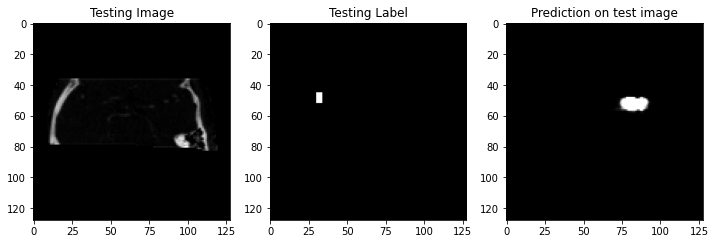

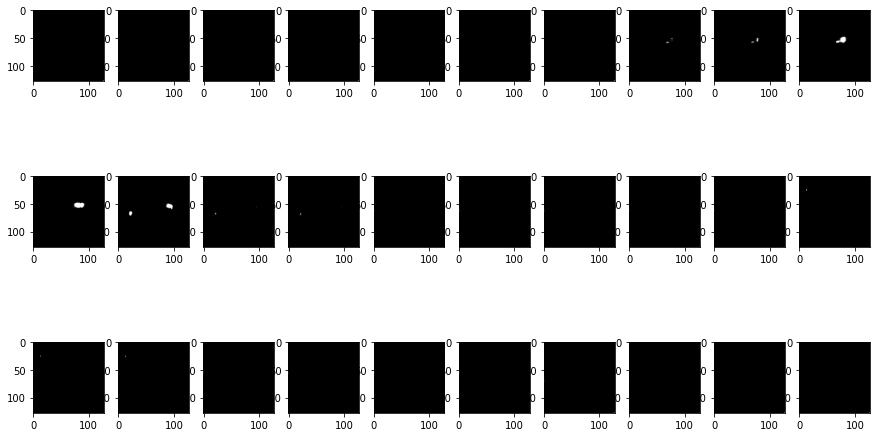

In [201]:
test_img_number = 168
test_img = X_train[test_img_number]
ground_truth=y_train[test_img_number]

test_img_input = np.expand_dims(test_img, 0)

test_pred1 = detection_model.predict(test_img_input)
#test_prediction1 = np.argmax(test_pred1, axis = 4)[0, :, :, :]
test_prediction1 = test_pred1[0, :, :, :, 0]
print(test_prediction1.shape)
ground_truth_argmax = ground_truth[:, :, :, 0]

print(test_prediction1.shape)
##plot the individual slices from test predictions 

slice = 11  #6-7 !!!
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
x_t=np.transpose(test_img, (2, 1, 0, 3))
#x_t = x_t[:, :, :, 0]
plt.imshow(x_t[slice], cmap='gray')
#plt.imshow(test_img[slice,:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
plt.imshow(y_t[slice], cmap ='gray')

plt.subplot(233)
plt.title('Prediction on test image')
y_p = np.transpose(test_prediction1, (2, 1, 0))
plt.imshow(y_p[slice], cmap = 'gray')
plt.show()

plt.figure(figsize=(15,30))
for i in range(30):
    plt.subplot(10, 10, i+1)
    plt.imshow(y_p[(i+1)], cmap='gray')